<a href="https://colab.research.google.com/github/trituenhantaoio/DeepLearning-Tutorial/blob/master/Hu%E1%BA%A5n_luy%E1%BB%87n_m%C3%B4_h%C3%ACnh_%C4%91%E1%BA%B7t_t%C3%AAn_Trituenhantao_io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Huấn luyện mô hình đặt tên
--------------------
Trong bài trước chúng ta đã huấn luyện mô hình để phát hiện các tên trong các ngôn ngữ khác nhau. Lần này, chúng ta sẽ huấn luyện mô hình đặt tên trong một ngôn ngữ được chỉ định trước.

Ví dụ:

```
> python sample.py Russian RUS
  Rovakov
  Uantov
  Shavakov
```
Ta sẽ thiết kế một mạng RNN với các lớp cơ bản. Thay vì phân loại các tên vào các ngôn ngữ, chúng ta sẽ làm bài toán ngược, với đầu vào là ngôn ngữ, mỗi bước mô hình sẽ đưa ra một ký tự để ghép thành tên hoàn chỉnh. Đây được coi là một "Mô hình ngôn ngữ" đơn giản.



Chuẩn bị dữ liệu
==================

Tải và giải nén dữ liệu tương tự như trong bài trước.

In [ ]:
%%capture
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -o data.zip

Tương tự trong bài trước, trong thư mục ``data/names`` chứa 18 file văn bản có dạng "[Ngôn ngữ].txt". Mỗi file chứa một loạt các tên, mỗi tên một dòng. Bước đầu tiên, ta cần chuyển các tên này từ bảng Unicode sang ASCII và đọc nội dung từ thư mục.

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

Tạo mạng nơ ron
====================

Mạng này giống bài trước với đối số thêm vào là tensor biểu diễn loại ngôn ngữ, tensor này sẽ được nối với đầu vào khác. Đây là một véc tơ one-hot giống như véc tơ biểu diễn các ký tự.

Đầu ra là phân bố xác suất của ký tự tiếp theo. Ký tự này sau đó lại trở thành đầu vào để dự đoán ký tự phía sau nó.

Lớp tuyến tính ``o2o`` được sử dụng để kết hợp trạng thái ẩn và đầu ra. Lớp [dropout](https://arxiv.org/abs/1207.0580) được sử dụng để xóa một phần tín hiệu đầu vào, buộc mạng phải ghi nhớ và dự đoán để khôi phục tín hiệu đầy đủ.


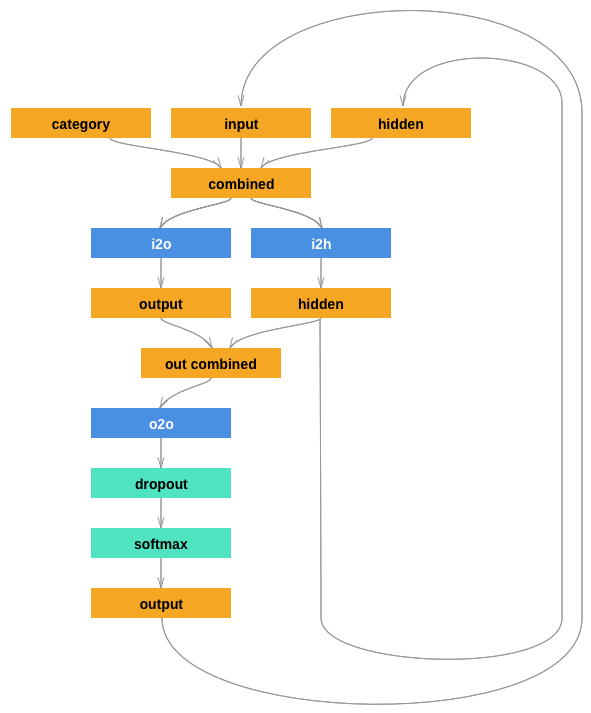

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Huấn luyện
=========
Chuẩn bị huấn luyện
----------------------

Đầu tiên ta cần có hàm hỗ trợ để đưa ra các cặp (category, line) là ngôn ngữ và các dòng (tên) trong file tương ứng:




In [ ]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

Tại mỗi bước, đầu vào của mạng sẽ là (ngôn ngữ, ký tự hiện tại, trạng thái ẩn) và đầu ra là (ký tự tiếp theo, trạng thái ẩn tiếp theo).
Với mỗi ví dụ, chúng ta sẽ cần ngôn ngữ (category), tập hợp ký tự đầu vào và tập hợp các ký tự đầu ra.

Vì chúng ta dự đoán ký tự tiếp theo từ ký tự hiện tại, các cặp ký tự sẽ là các ký tự liên tiếp nhau trong một dòng. Ví dụ từ ``"ABCD<EOS>"``, ta sẽ có ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS") với EOS là ký tự kết thúc.

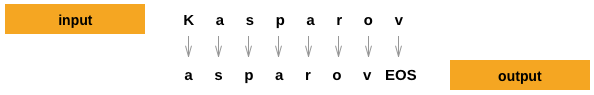

Category tensor biểu diễn ngôn ngữ là một véc tơ [one-hot](https://trituenhantao.io/tu-dien-thuat-ngu/one-hot/) có kích thước
``<1 x n_categories>``. 
Ta cần đưa tensor này vào từng bước huấn luyện như đã thiết kế.




In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

Để tiện cài đặt, trong quá trình huấn luyện ta sẽ sử dụng hàm ``randomTrainingExample``
để tải ngẫu nhiên cặp (category, line) và biến chúng thành các tensor (category, input, target).




In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

Huấn luyện mô hình
--------------------

Trái với bài toán phân lớp, ta không chỉ sử dụng kết quả của lớp cuối cùng mà sẽ dự đoán và lấy kết quả ở mọi bước tính toán. Do đó, loss được tính ở tất cả các bước.

[Autograd](https://www.youtube.com/watch?v=iwx3Fp5iaqg) cho phép chúng ta cộng các giá trị loss lại và lan truyền ngược ở bước cuối.




In [ ]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

Hàm
``timeSince(timestamp)`` giúp ta theo dõi được quá trình huấn luyện.




In [ ]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

``print_every`` và ``plot_every`` giúp chỉ định tần số của việc in ra màn hình cũng như lưu giá trị loss trung bình.

In [ ]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Biểu diễn loss trên đồ thị




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Lấy mẫu
====================

Để lấy mẫu, ta sẽ cho mô hình biết một ký tự và hỏi nó ký tự tiếp theo. Quá trình lặp lại cho đến khi gặp ký tự kết thúc ``EOS``.

-  Tạo tensor cho đầu vào (ngôn ngữ, ký tự bắt đầu và trạng thái ẩn rỗng)
-  Tạo chuỗi ``output_name`` với ký tự bắt đầu
-  Lặp lại quá trình cho đến giới hạn độ dài tối đa:

   -  Đưa ký tự hiện tại vào mạng
   -  Lấy ra đầu ra có xác suất cao nhất và trạng thái ẩn tương ứng
   -  Nếu gặp ``EOS``, kết thúc
   -  Nếu gặp ký tự thường, thêm vào ``output_name`` và tiếp tục.

-  Trả về kết quả

Lưu ý: Nếu như ta huấn luyện mô hình với ký tự bắt đầu chuỗi ``SOS``, mô hình sẽ có thể tự quyết định ký tự đầu tiên mà không cần sự can thiệp của chúng ta.



In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [ ]:
samples('English', 'AB')

In [ ]:
samples('Russian', 'CD')

In [ ]:
samples('Vietnamese','AT')

Bài tập
=========

-  Thử với các dataset khác, ví dụ:

   -  Tên tác phẩm -> Tên nhân vật
   -  Từ loại -> Từ
   -  Quốc gia -> Tỉnh, thành phố

-  Sử dụng token bắt đầu ``SOS`` để việc lấy mẫu không cần chỉ định 
-  Thử các kiến trúc và cấu hình khác:

   -  Thử các lớp nn.LSTM và nn.GRU
   -  Kết hợp các lớp RNN thành kiến trúc phức tạp hơn




**Nội dung và mã nguồn**: [Sean Robertson](https://github.com/spro/practical-pytorch)

**Dịch và biên soạn lại**: [trituenhantao.io](https://trituenhantao.io)